# Implementation of face recognition using neural net 

In [1]:
%matplotlib inline

In [2]:
import cv2
import numpy as np
import os
from skimage import io
from sklearn.cross_validation import train_test_split
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report,accuracy_score
from sklearn.neural_network import MLPClassifier


/Users/arjun/opencv/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [3]:
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras import metrics

Using TensorFlow backend.


#### Listing the path of all the images

In [4]:
DatasetPath = []
for i in os.listdir("yalefaces"):
    DatasetPath.append(os.path.join("yalefaces", i))

#### Reading each image and assigning respective labels

In [5]:
imageData = []
imageLabels = []

In [6]:
for i in DatasetPath:
    imgRead = io.imread(i,as_grey=True)
    imageData.append(imgRead)
    
    labelRead = int(os.path.split(i)[1].split(".")[0].replace("subject", "")) - 1
    imageLabels.append(labelRead)

#### Preprocessing: Face Detection using OpenCV and cropping the image to a size of 150 * 150

In [7]:
faceDetectClassifier = cv2.CascadeClassifier("haarcascade_frontalface_default.xml")
imageDataFin = []
for i in imageData:
    facePoints = faceDetectClassifier.detectMultiScale(i)
    x,y = facePoints[0][:2]
    cropped = i[y: y + 150, x: x + 150]
    imageDataFin.append(cropped)

In [8]:
c = np.array(imageDataFin)

In [9]:
c.shape

(165, 150, 150)

#### Splitting Dataset into train and test

In [10]:
X_train, X_test, y_train, y_test = train_test_split(np.array(imageDataFin),np.array(imageLabels), train_size=0.7, random_state = 20)

In [11]:
X_train = np.array(X_train)
X_test = np.array(X_test)

In [12]:
X_train.shape

(115, 150, 150)

In [13]:
X_test.shape

(50, 150, 150)

In [14]:
nb_classes = 15
y_train = np.array(y_train) 
y_test = np.array(y_test) 

In [15]:
Y_train = np_utils.to_categorical(y_train, nb_classes)
Y_test = np_utils.to_categorical(y_test, nb_classes)

#### Converting each 2d image into 1D vector

In [16]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1]*X_train.shape[2])
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1]*X_test.shape[2])
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

# normalize the data
X_train /= 255
X_test /= 255

#### Preprocessing -PCA

Plot of amount of variance explained vs pcs


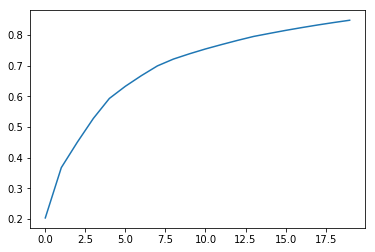

('Training PCA shape', (115, 20))
('Test PCA shape', (50, 20))
Eigen Faces


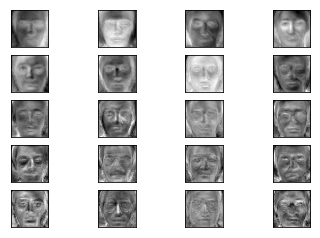

In [17]:
computed_pca = PCA(n_components = 20,whiten=True).fit(X_train)
XTr_pca = computed_pca.transform(X_train)

print("Plot of amount of variance explained vs pcs")
plt.plot(range(len(computed_pca.explained_variance_)),np.cumsum(computed_pca.explained_variance_ratio_))
plt.show()

XTs_pca = computed_pca.transform(X_test)
print("Training PCA shape",XTr_pca.shape)
print("Test PCA shape",XTs_pca.shape)


def plot_eigenfaces(images, h, w, rows=5, cols=4):
    plt.figure()
    for i in range(rows * cols):
        plt.subplot(rows, cols, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.xticks(())
        plt.yticks(())
plot_eigenfaces(computed_pca.components_,150,150)
print("Eigen Faces")

In [18]:
print("Original Training matrix shape", X_train.shape)
print("Original Testing matrix shape", X_test.shape)

('Original Training matrix shape', (115, 22500))
('Original Testing matrix shape', (50, 22500))


#### Defining the model

In [19]:
model = Sequential()
model.add(Dense(512,input_shape=(XTr_pca.shape[1],)))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(nb_classes))
model.add(Activation('softmax'))

In [20]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 512)               10752     
_________________________________________________________________
activation_1 (Activation)    (None, 512)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               262656    
_________________________________________________________________
activation_2 (Activation)    (None, 512)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 15)                7695      
__________

In [21]:
model.compile(loss='categorical_crossentropy', optimizer="adam", metrics=[metrics.mae,metrics.categorical_accuracy])

#### Training

In [22]:
model.fit(XTr_pca, Y_train, batch_size=64, epochs=50, verbose=1, validation_data=(XTs_pca, Y_test))

Train on 115 samples, validate on 50 samples
Epoch 1/50
115/115 [==============================] - 1s 5ms/step - loss: 2.7068 - mean_absolute_error: 0.1242 - categorical_accuracy: 0.0609 - val_loss: 2.4532 - val_mean_absolute_error: 0.1216 - val_categorical_accuracy: 0.4800
Epoch 2/50
115/115 [==============================] - 0s 217us/step - loss: 2.3073 - mean_absolute_error: 0.1196 - categorical_accuracy: 0.5826 - val_loss: 2.2011 - val_mean_absolute_error: 0.1179 - val_categorical_accuracy: 0.8000
Epoch 3/50
115/115 [==============================] - 0s 201us/step - loss: 1.9279 - mean_absolute_error: 0.1128 - categorical_accuracy: 0.9304 - val_loss: 1.9530 - val_mean_absolute_error: 0.1128 - val_categorical_accuracy: 0.8200
Epoch 4/50
115/115 [==============================] - 0s 224us/step - loss: 1.5920 - mean_absolute_error: 0.1044 - categorical_accuracy: 0.9565 - val_loss: 1.6960 - val_mean_absolute_error: 0.1057 - val_categorical_accuracy: 0.8200
Epoch 5/50
115/115 [=========

Epoch 36/50
115/115 [==============================] - 0s 290us/step - loss: 0.0057 - mean_absolute_error: 7.4388e-04 - categorical_accuracy: 1.0000 - val_loss: 0.4634 - val_mean_absolute_error: 0.0230 - val_categorical_accuracy: 0.8800
Epoch 37/50
115/115 [==============================] - ETA: 0s - loss: 0.0062 - mean_absolute_error: 8.2041e-04 - categorical_accuracy: 1.00 - 0s 272us/step - loss: 0.0049 - mean_absolute_error: 6.4630e-04 - categorical_accuracy: 1.0000 - val_loss: 0.4630 - val_mean_absolute_error: 0.0229 - val_categorical_accuracy: 0.8800
Epoch 38/50
115/115 [==============================] - 0s 244us/step - loss: 0.0046 - mean_absolute_error: 6.0908e-04 - categorical_accuracy: 1.0000 - val_loss: 0.4632 - val_mean_absolute_error: 0.0228 - val_categorical_accuracy: 0.8800
Epoch 39/50
115/115 [==============================] - 0s 281us/step - loss: 0.0053 - mean_absolute_error: 6.8710e-04 - categorical_accuracy: 1.0000 - val_loss: 0.4640 - val_mean_absolute_error: 0.0228

#### Evaluating the performance

In [23]:
loss,mean_absolute_error,accuracy = model.evaluate(XTs_pca,Y_test, verbose=0)

In [24]:
print("Loss:", loss)
print("Categorical Accuracy: ", accuracy)
print("Mean absolute error: ", mean_absolute_error)

('Loss:', 0.47648099839687347)
('Categorical Accuracy: ', 0.86000000238418584)
('Mean absolute error: ', 0.022233321815729141)


In [25]:
predicted_classes = model.predict_classes(XTs_pca)

In [26]:
correct_classified_indices = np.nonzero(predicted_classes == y_test)[0]
incorrect_classified_indices = np.nonzero(predicted_classes != y_test)[0]

In [27]:
correct_classified_indices

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 12, 13, 14, 15, 16, 17, 18,
       19, 21, 22, 23, 24, 26, 27, 29, 30, 31, 33, 34, 35, 36, 37, 38, 39,
       40, 42, 43, 44, 45, 46, 47, 48, 49])

In [28]:
incorrect_classified_indices

array([ 0, 11, 20, 25, 28, 32, 41])

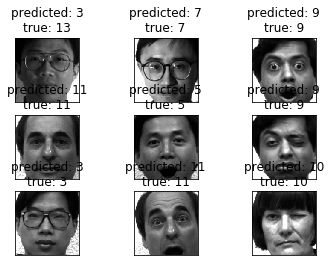

In [30]:
# Visualization
def plot_gallery(images, titles, h, w, rows=3, cols=3):
    plt.figure()
    for i in range(rows * cols):
        plt.subplot(rows, cols, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i])
        plt.xticks(())
        plt.yticks(())
 
def titles(y_pred, y_test):
    for i in range(y_pred.shape[0]):
        pred_name = y_pred[i]
        true_name = y_test[i]
        yield 'predicted: {0}\ntrue: {1}'.format(pred_name, true_name)
        
prediction_titles = list(titles(predicted_classes, y_test))
plot_gallery(X_test, prediction_titles, 150, 150)

